<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/josh-updates/josh-AoA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [42]:
# installers
import sys
# !{sys.executable} -m pip install pyspark -q
# !{sys.executable} -m pip install -U spacy -q
!{sys.executable} -m spacy download en_core_web_lg -q
# !{sys.executable} -m pip install sklearn -q

# imports
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import clean_wiki as cw  # custom cleaning module

2022-10-02 15:18:23.948856: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 8.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [43]:
n = 10000  # sample size (number if > 1 else fraction)

grade_level = [   # school level by age
    (3, 4, 0, 'Foundation'),
    (4, 5, 0, 'Foundation'),
    (5, 6, 1, 'Primary'),
    (6, 7, 1, 'Primary'),
    (7, 8, 1, 'Primary'),
    (8, 9, 1, 'Primary'),
    (9, 10, 1, 'Primary'),
    (10, 11, 1, 'Primary'),
    (11, 12, 2, 'MiddleSchool'),
    (12, 13, 2, 'MiddleSchool'),
    (13, 14, 2, 'MiddleSchool'),
    (14, 15, 3, 'IGCSE'),
    (15, 16, 3, 'IGCSE'),
    (16, 17, 3, 'IB'),
    (17, 18, 3, 'IB'),
    (19, 200, 3, 'College')
]

def grade_finder(age):
  for i in grade_level:
    if i[0] <= age <= i[1]:
      return i[2]
  return -1

## Dataset

In [44]:
df = cw.process_file('WikiLarge_Train.csv')
df.head()

root
 |-- original_text: string (nullable = true)
 |-- label: string (nullable = true)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|original_text                                                                                                                                                                                                                                           |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephe

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [45]:
df_sample = df.sample(n) if n >= 1 else df.sample(frac=n)

## Lemmatize (and then some)

In [46]:
nlp = spacy.load('en_core_web_lg')
tokens = []
for doc in nlp.pipe(df_sample['original_text'], n_process=4):
  tokens.append([w.lemma_ for w in doc])

In [47]:
df_AoA = pd.read_csv('AoA_51715_words.csv', encoding= 'unicode_escape')

# load words and ages into dictionary
age = {}
for _, w in df_AoA.iterrows():
  age[w[0]] = w[10]
  if w[0] != w[1]:
    age[w[1]] = w[10]

df_AoA.sample(10)

,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock
19603,gives,gives,64.51,Verb,5,4,1,give,NaN,NaN,4.28,1.00,4.68,NaN,3.82,NaN
16443,expired,expired,2.51,Verb,7,7,2,expire,NaN,NaN,7.68,1.00,NaN,NaN,NaN,8.28
24791,jalopy,jalopy,0.71,Noun,6,6,3,jalopy,10.21,0.78,10.21,0.78,NaN,NaN,NaN,NaN
50273,warnings,warnings,1.59,Noun,8,7,2,warning,NaN,NaN,6.11,1.00,6.81,NaN,NaN,NaN
37958,reportage,reportage,0.12,Noun,9,8,3,reportage,14.00,0.65,14.00,0.65,NaN,NaN,NaN,NaN
24203,interactions,interactions,0.25,Noun,12,10,4,interaction,NaN,NaN,9.42,1.00,NaN,NaN,NaN,NaN
17867,flirtation,flirtation,0.71,Noun,10,8,3,flirtation,10.53,1.00,10.53,1.00,NaN,NaN,NaN,NaN
23357,inconsequentiality,inconsequentiality,0.04,Noun,18,17,7,inconsequentiality,15.11,1.00,15.11,1.00,NaN,NaN,NaN,NaN
25678,lameness,lameness,0.10,Noun,8,6,2,lameness,11.47,0.89,11.47,0.89,NaN,NaN,NaN,NaN
46821,torching,torching,0.25,Verb,8,6,2,torch,NaN,NaN,7.84,1.00,NaN,5.48,9.02,NaN


## Basic Features

In [48]:
df_sample.head()

,original_text,label
320063,Diagonal is a city of Iowa in the United States .,0
266599,"In England and Wales and Ireland , the lord li...",0
24739,"The Condé Nast Building , officially 4 Times S...",1
365883,It was created on model Cyrillic letter by Vuk...,0
2183,The county is served by the Carteret County Pu...,1


In [49]:
# Basic stats
df_sample['num_lemmas'] = [len(s) for s in tokens]
df_sample['min_age'] = [np.nanmin([age.get(w, np.nan) for w in s]) for s in tokens]
df_sample['mean_age'] = [np.nanmean([age.get(w, np.nan) for w in s]) for s in tokens]
df_sample['max_age'] = [np.nanmax([age.get(w, np.nan) for w in s]) for s in tokens]
df_sample['num_listed'] = [len([w for w in s if age.get(w,0) > 0]) for s in tokens]
df_sample['num_unlisted'] = df_sample['num_lemmas'] - df_sample['num_listed']

# Grade level
df_sample['grade_min_age'] = df_sample['min_age'].apply(lambda x: grade_finder(x))
df_sample['grade_mean_age'] = df_sample['mean_age'].apply(lambda x: grade_finder(x))
df_sample['grade_max_age'] = df_sample['max_age'].apply(lambda x: grade_finder(x))

# Made up stuff
df_sample['ma-sl'] = df_sample['max_age'] * df_sample['num_lemmas'] # Max Age * Sentence Length
df_sample['ma-isl'] = df_sample['max_age'] * (1 / df_sample['num_lemmas']) # Max Age * Inverse Sentence Length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN axis encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN axis encountered
  """


## Feature Statistics

In [50]:
means = df_sample.mean()
sdevs = df_sample.std()

mdict = {}
for m in means:
  mdict[means[means==m].index[0]] = m

sdict = {}
for s in sdevs:
  sdict[sdevs[sdevs==s].index[0]] = s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


## Z-Score Features

In [51]:
df_sample.columns[2:13]

Index(['num_lemmas', 'min_age', 'mean_age', 'max_age', 'num_listed',
       'num_unlisted', 'grade_min_age', 'grade_mean_age', 'grade_max_age',
       'ma-sl', 'ma-isl'],
      dtype='object')

In [52]:
for c in df_sample.columns[2:11]:
  df_sample[f'z_{c}'] = (df_sample[c] - means[c]) / sdevs[c]

df_sample.head()

,original_text,label,num_lemmas,min_age,mean_age,max_age,num_listed,num_unlisted,grade_min_age,grade_mean_age,...,ma-isl,z_num_lemmas,z_min_age,z_mean_age,z_max_age,z_num_listed,z_num_unlisted,z_grade_min_age,z_grade_mean_age,z_grade_max_age
320063,Diagonal is a city of Iowa in the United States .,0,11,2.89,4.463333,6.56,6,5,-1,0,...,0.596364,-1.018439,-0.605527,-1.326213,-1.400249,-0.950270,-0.623592,-0.952873,-1.581341,-0.541702
266599,"In England and Wales and Ireland , the lord li...",0,18,3.69,5.428462,9.50,13,5,0,1,...,0.527778,-0.453370,0.423971,-0.215201,-0.249045,-0.168679,-0.623592,0.908935,0.527676,-0.541702
24739,"The Condé Nast Building , officially 4 Times S...",1,21,2.89,5.171429,8.58,7,14,-1,1,...,0.408571,-0.211198,-0.605527,-0.511086,-0.609286,-0.838614,0.743401,-0.952873,0.527676,-0.541702
365883,It was created on model Cyrillic letter by Vuk...,0,12,4.01,5.228571,7.10,7,5,0,1,...,0.591667,-0.937715,0.835770,-0.445305,-1.188803,-0.838614,-0.623592,0.908935,0.527676,-0.541702
2183,The county is served by the Carteret County Pu...,1,12,3.98,5.758333,8.90,6,6,0,1,...,0.741667,-0.937715,0.797164,0.164533,-0.483985,-0.950270,-0.471703,0.908935,0.527676,-0.541702


## Feature Importance

In [53]:
# Nan's break the model
df_clean = df_sample.dropna()

In [54]:
X = df_clean[df_clean.columns[2:]]
y = df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
pipeline = Pipeline([('model',Lasso(random_state=42))])
search = GridSearchCV(pipeline,{'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error", verbose=0)
search.fit(X_train,y_train)
search.best_params_

{'model__alpha': 0.1}

In [56]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print(importance)

[0.         0.         0.         0.         0.00095921 0.
 0.         0.         0.         0.00079764 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [57]:
cols = list(df_clean.columns[2:][importance > 0])
cols

['num_listed', 'ma-sl']

## Regression

In [58]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train[cols], y_train)
pred = lr.predict(X_test[cols])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63       934
           1       0.66      0.61      0.63      1035

    accuracy                           0.63      1969
   macro avg       0.63      0.63      0.63      1969
weighted avg       0.63      0.63      0.63      1969



In [59]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
pca = PCA(n_components=X_scaled.shape[1], random_state=42)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 37.46808112,  65.07760874,  79.88204055,  86.62839435,
        92.52984988,  95.95502377,  97.64574979,  98.97250247,
        99.86826341, 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ])

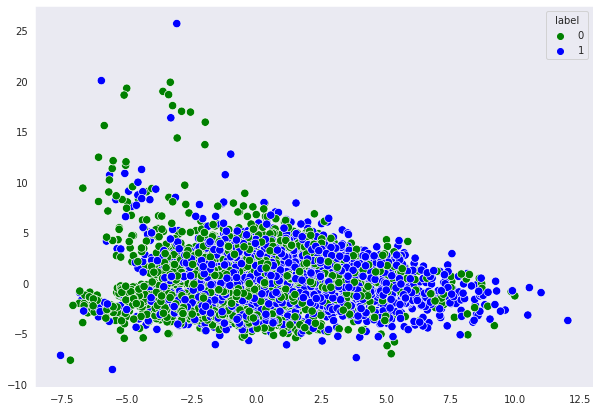

In [61]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], s=70, hue=y_train, palette=['green','blue'])
plt.show()

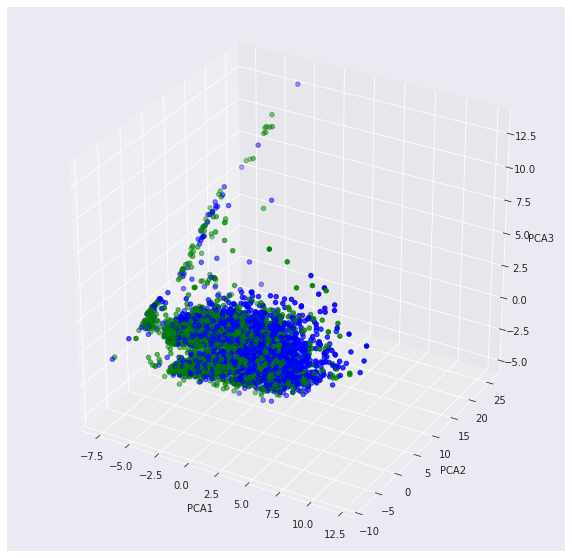

In [62]:
sns.set_style("darkgrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=['green' if i=='0' else 'blue' for i in y_train], marker='o')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

In [63]:
import collections
collections.Counter(y_train)


Counter({'0': 3768, '1': 4104})

In [64]:
X_test_pca = pca.transform(X_test_scaled)
lr = LogisticRegression(max_iter=10000)
lr.fit(X_pca[:,:4], y_train)
pred = lr.predict(X_test_pca[:,:4])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       934
           1       0.64      0.68      0.66      1035

    accuracy                           0.63      1969
   macro avg       0.63      0.63      0.63      1969
weighted avg       0.63      0.63      0.63      1969

